In [1]:
from fastai.vision.all import *

In [2]:
top_edge = tensor([
    [-1,-1,-1],
    [ 0, 0, 0],
    [ 1, 1, 1]
]).float()
top_edge

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
path.ls()

(#3) [Path('/home/jupyter/.fastai/data/mnist_sample/train'),Path('/home/jupyter/.fastai/data/mnist_sample/labels.csv'),Path('/home/jupyter/.fastai/data/mnist_sample/valid')]

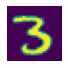

In [5]:
im3 = Image.open(path/'train'/'3'/'12.png'); 
show_image(im3);

In [6]:
im3_t = tensor(im3)
im3_t[0:3,0:3]

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=torch.uint8)

In [7]:
im3_t[0:3,0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [8]:
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

In [9]:
df = pd.DataFrame(im3_t[:10,:20])
df.style.background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [10]:
im3_t[4:7,6:9]

tensor([[  0,   0,   0],
        [142, 155, 246],
        [254, 254, 254]], dtype=torch.uint8)

In [11]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

In [12]:
im3_t[7:10,17:20]

tensor([[254,  75,   0],
        [254, 153,   0],
        [247,  53,   0]], dtype=torch.uint8)

In [13]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

So our kernel is detecting top edges, in the sense that it returns big numbers when the pixel values are low at the top and high at the bottom 

In [14]:
def apply_kernel_at(row, col, kernel):
    """
    Apply kernel to to the image at (row, col)
    """
    # I made it more general, using the shape of the kernel 
    height, width = kernel.shape 
    return (im3_t[row-1:row + height-1, col-1: col + width-1] * kernel).sum()

In [15]:
apply_kernel_at(5,7,top_edge)

tensor(762.)

In [16]:
apply_kernel_at(7,2,top_edge)

tensor(-103.)

In [17]:
# this is a bottom edge, hence returning a large negative number 
apply_kernel_at(8,8,top_edge)

tensor(-613.)

## Mapping a Convolutional Kernel 

Lets apply our kernel to all possible positions in the grid instead of just one 

In [18]:
height, width = im3_t.shape
height, width

(28, 28)

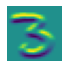

In [19]:
rng = range(1,27)
# apply our top_edge kernel to all positions 
top_edge3 = tensor([[apply_kernel_at(i,j,top_edge) for j in range(1,height-1)] for i in range(1,width-1)])
show_image(top_edge3);

In [20]:
top_edge3.min()

tensor(-762.)

In [21]:
def apply_kernel(im, kernel):
    height, width = im3_t.shape
    return tensor([[apply_kernel_at(i,j,kernel) for j in range(1,height-1)] for i in range(1,width-1)])

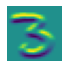

In [22]:
show_image(apply_kernel(im3_t, top_edge));

In [23]:
# odd that we're going -1,1,0 rather than -1,0,1 as with top edges 
left_edge = tensor([
    [-1,1,0],
    [-1,1,0],
    [-1,1,0]
]).float()
left_edge


tensor([[-1.,  1.,  0.],
        [-1.,  1.,  0.],
        [-1.,  1.,  0.]])

In [24]:
apply_kernel_at(7,3,left_edge)

tensor(393.)

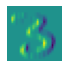

In [25]:
left_edge3 = apply_kernel(im3_t, left_edge)
show_image(left_edge3);

In [26]:
left_edge3.shape

torch.Size([26, 26])

Note how the size went from 28x28 image to a 26x26 image, since we only get to apply the kernel n - 2 times along a given axis

## Convolutions in PyTorch 

In [27]:
from torch.nn.functional import conv2d

In [29]:
F.conv2d == conv2d

True

* pytorch can apply a kernel to multiple images at once 
* pytorch can apply multiple kernels at once 

In [32]:
diag1_edge = tensor([
    [0,-1, 1],
    [-1,1, 0],
    [1, 0, 0]
]).float()
diag2_edge = tensor([
    [1,-1, 0],
    [0, 1,-1],
    [0, 0, 1]
])

In [52]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge]); edge_kernels

tensor([[[-1.,  1.,  0.],
         [-1.,  1.,  0.],
         [-1.,  1.,  0.]],

        [[-1., -1., -1.],
         [ 0.,  0.,  0.],
         [ 1.,  1.,  1.]],

        [[ 0., -1.,  1.],
         [-1.,  1.,  0.],
         [ 1.,  0.,  0.]],

        [[ 1., -1.,  0.],
         [ 0.,  1., -1.],
         [ 0.,  0.,  1.]]])

In [53]:
edge_kernels.shape

torch.Size([4, 3, 3])

In [54]:
mnist = DataBlock(
    (ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items = get_image_files,
    splitter = GrandparentSplitter(),
    get_y=parent_label
)

In [55]:
dls = mnist.dataloaders(path)

In [56]:
xb,yb = first(dls.valid)

In [57]:
xb.shape

torch.Size([64, 1, 28, 28])

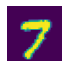

In [68]:
show_image(xb[3]);

In [58]:
xb,yb = to_cpu(xb), to_cpu(yb)

In [59]:
# (out_feature, channel, row, col)  
edge_kernels.shape, edge_kernels.unsqueeze(1).shape 

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [60]:
edge_kernels = edge_kernels.unsqueeze(1)

In [61]:
batch_features = F.conv2d(xb, edge_kernels); batch_features.shape

torch.Size([64, 4, 26, 26])

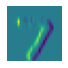

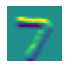

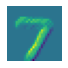

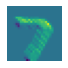

In [81]:
# left, top, diagonal (topleft -> bottomright), diagnonal (bottomleft -> topright)
for i in range(4):
    show_image(batch_features[0,i]);

## Our First Convolutional Neural Network 